<a href="https://colab.research.google.com/github/MadhurimaPaul-87/Machine_Learning/blob/main/Transfer_Learning_Tensor_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

**PART 1: USE A TENSORFLOW HUB MOBILENET FOR PREDICTION**

**Download the Classifier**

In [3]:
CLASSIFIER_URL='https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2'
IMAGE_RES=224

model= tf.keras.Sequential([
       hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES,IMAGE_RES,3))                     
])

**Run it on a single image**

65536/61306 [================================] - 0s 0us/step


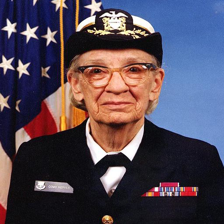

In [4]:
import numpy as np
import PIL.Image as Image

grace_hopper= tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper=Image.open(grace_hopper).resize((IMAGE_RES,IMAGE_RES))
grace_hopper

In [5]:
grace_hopper=np.array(grace_hopper)/255.
grace_hopper.shape

(224, 224, 3)

In [6]:
result= model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [7]:
predicted_class= np.argmax(result[0],axis=-1)
predicted_class

653

**Decode the prediction**

16384/10484 [==============================================] - 0s 0us/step


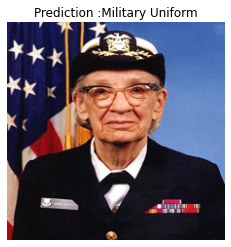

In [9]:
labels_path= tf.keras.utils.get_file("ImageNetLabels.txt",'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name= imagenet_labels[predicted_class]
_= plt.title("Prediction :" + predicted_class_name.title())

**Part 2: Use a Tensorflow Hub models for the Cats vs. Dogs dataset**

**Dataset**

In [36]:
(training_set, validation_set), dataset_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [37]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 2
Total Number of Training Images: 18610
Total Number of Validation Images: 4652 



In [38]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (262, 350, 3) label: 1
Image 2 shape: (409, 336, 3) label: 1
Image 3 shape: (493, 500, 3) label: 1
Image 4 shape: (375, 500, 3) label: 0
Image 5 shape: (240, 320, 3) label: 1


In [39]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

**Run the classifier on a batch of images**

In [40]:
image_batch,label_batch= next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch= label_batch.numpy()
result_batch= model.predict(image_batch)

predicted_class_names= imagenet_labels[np.argmax(result_batch, axis= -1)]
predicted_class_names

array(['Siamese cat', 'miniature pinscher', 'hamster', 'tabby', 'tabby',
       'Persian cat', 'chow', 'Persian cat', 'redbone', 'Egyptian cat',
       'tabby', 'Persian cat', 'Egyptian cat', 'Egyptian cat',
       'Persian cat', 'bloodhound', 'kelpie', 'kelpie', 'tabby',
       'Egyptian cat', 'tabby', 'tabby', 'Pomeranian', 'Persian cat',
       'Shetland sheepdog', 'dingo', 'Yorkshire terrier', 'Egyptian cat',
       'papillon', 'Egyptian cat', 'tabby', 'Leonberg'], dtype='<U30')

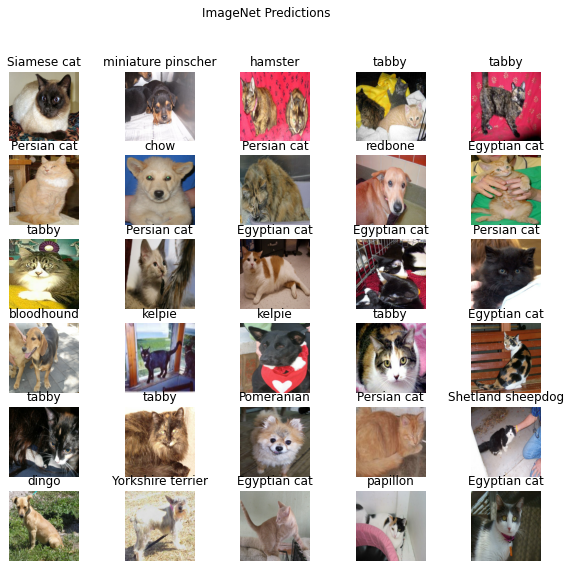

In [41]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_=plt.suptitle("ImageNet Predictions")

**Part 3: Simpe transfer learning with tensorflow hub**

In [45]:
URL='https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'
IMAGE_RES=224

feature_extractor= hub.KerasLayer(URL, input_shape=(IMAGE_RES,IMAGE_RES,3))                     


In [46]:
feature_batch= feature_extractor(image_batch)
feature_batch.shape

TensorShape([32, 1280])

In [47]:
feature_extractor.trainable=False

**Attach a classification head**

In [48]:
model= tf.keras.Sequential([feature_extractor,layers.Dense(2,activation='softmax')])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


**Train the model**

In [51]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 808s 1s/step - loss: 0.0750 - accuracy: 0.9761 - val_loss: 0.0320 - val_accuracy: 0.9888
Epoch 2/6
582/582 [==============================] - 800s 1s/step - loss: 0.0315 - accuracy: 0.9902 - val_loss: 0.0319 - val_accuracy: 0.9877
Epoch 3/6
582/582 [==============================] - 807s 1s/step - loss: 0.0276 - accuracy: 0.9910 - val_loss: 0.0319 - val_accuracy: 0.9895
Epoch 4/6
582/582 [==============================] - 806s 1s/step - loss: 0.0236 - accuracy: 0.9918 - val_loss: 0.0351 - val_accuracy: 0.9882
Epoch 5/6
582/582 [==============================] - 809s 1s/step - loss: 0.0217 - accuracy: 0.9929 - val_loss: 0.0388 - val_accuracy: 0.9884
Epoch 6/6
582/582 [==============================] - 794s 1s/step - loss: 0.0175 - accuracy: 0.9938 - val_loss: 0.0314 - val_accuracy: 0.9897


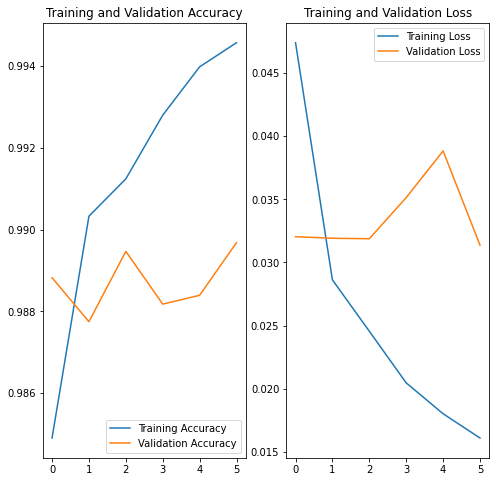

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Check the prediction**

In [53]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['cat' 'dog']


In [60]:
predicted_batch= model.predict(image_batch)
predicted_batch= tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['cat' 'dog' 'cat' 'cat' 'cat' 'cat' 'dog' 'cat' 'dog' 'cat' 'cat' 'cat'
 'cat' 'cat' 'cat' 'dog' 'cat' 'dog' 'cat' 'cat' 'cat' 'cat' 'dog' 'cat'
 'cat' 'dog' 'dog' 'cat' 'cat' 'cat' 'cat' 'dog']


In [61]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1]
Predicted labels:  [0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1]


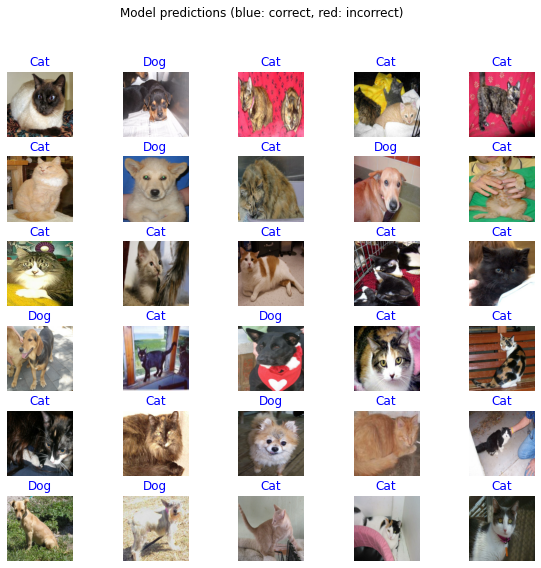

In [62]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")